# CODE FOR CUSTOMER SEGMENTATION
# SCALING 

In [1]:
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns
from datetime import datetime 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import pairwise_distances_argmin
import os


In [2]:
directory = 'C:\\Users\\e.avgeraki\\Downloads\\Data_efood'
df= pd.read_csv(directory+'\\orders.csv',sep=',')
df



,order_id,user_id,order_timestamp,city,cuisine,paid_cash,amount
0,7322173742136,94223136441,2022-01-18 15:41:28 UTC,Αίγιο,Breakfast,True,3.6
1,7210978616924,204794985423,2022-01-02 17:50:50 UTC,Αγρίνιο,Breakfast,True,1.9
2,7221232906132,12703920390,2022-01-04 08:37:12 UTC,Αγρίνιο,Breakfast,True,1.7
3,7399605199800,673310109528,2022-01-31 11:33:05 UTC,Λιβαδειά,Breakfast,True,3.0
4,7264221279744,673310109528,2022-01-10 11:18:28 UTC,Λιβαδειά,Breakfast,True,3.0
...,...,...,...,...,...,...,...
534265,7383295241752,314285338626,2022-01-28 22:25:04 UTC,Αλεξανδρούπολη,Street food,True,11.9
534266,7383425578320,586121418057,2022-01-28 22:39:29 UTC,Αλεξανδρούπολη,Street food,True,9.9
534267,7364485291992,29082002418,2022-01-24 19:29:34 UTC,Αλεξανδρούπολη,Street food,True,15.1
534268,7231345759480,348528607896,2022-01-05 18:28:41 UTC,Αλεξανδρούπολη,Street food,True,14.7


# Aggregate the data in order to calculate the key variables

In [3]:
# use groupby to summarize total amount of sales and count distinct orders per CustomerID
customer_df = df.groupby('user_id').agg({'amount': sum, 
                                         'order_id': lambda x: x.nunique()})

# Select the columns we want to use
customer_df.columns = ['Ordervalue', 'Frequency'] 

# create a new column 'AvgOrderValue'
customer_df['AvgOrderValue'] = customer_df['Ordervalue'] / customer_df['Frequency']
customer_df.head()

,Ordervalue,Frequency,AvgOrderValue
user_id,,,
44118921,33.3,1,33.300000
108938802,44.2,3,14.733333
110361993,137.0,11,12.454545
138437670,5.5,1,5.500000
144777339,60.8,14,4.342857


# Normalize the data

In [4]:
rank_df = customer_df.rank(method='first')
normalized_df = (rank_df - rank_df.mean()) / rank_df.std()
normalized_df.head(10)

,Ordervalue,Frequency,AvgOrderValue
user_id,,,
44118921,0.454661,-1.732030,1.707287
108938802,0.788022,0.034799,1.188879
110361993,1.617207,1.407077,0.889778
138437670,-1.491277,-1.732001,-1.063034
144777339,1.115361,1.528291,-1.423951
145424244,1.660784,1.455852,1.056984
153963390,0.565137,0.034828,0.848132
155515962,-1.491248,-1.731973,-1.063006
165219537,-1.616695,-1.731944,-1.437899


# Elbow method

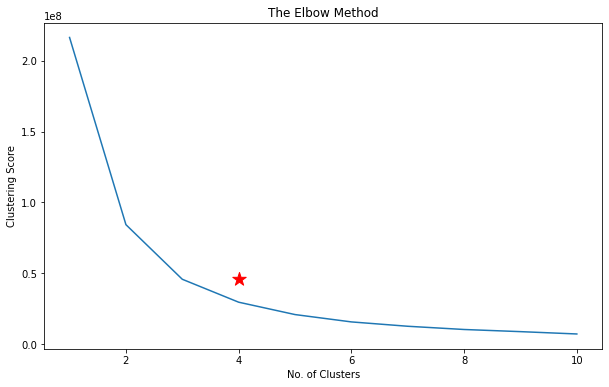

In [5]:
X = customer_df[['Ordervalue','Frequency']].values
clustering_score = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'random', random_state = 42)
    kmeans.fit(X)
    clustering_score.append(kmeans.inertia_) # inertia_ = Sum of squared distances of samples to their closest cluster center.
    

plt.figure(figsize=(10,6))
plt.plot(range(1, 11), clustering_score)
plt.scatter(4,clustering_score[2], s = 200, c = 'red', marker='*')
plt.title('The Elbow Method')
plt.xlabel('No. of Clusters')
plt.ylabel('Clustering Score')
plt.show()

# Interpreting Customer Segments

In [6]:
kmeans = KMeans(n_clusters=3).fit(normalized_df[['Ordervalue', 'Frequency']])

four_cluster_df = normalized_df[['Ordervalue','Frequency']].copy(deep=True)
four_cluster_df['Cluster'] = kmeans.labels_
four_cluster_df



,Ordervalue,Frequency,Cluster
user_id,,,
44118921,0.454661,-1.732030,0
108938802,0.788022,0.034799,2
110361993,1.617207,1.407077,1
138437670,-1.491277,-1.732001,0
144777339,1.115361,1.528291,1
...,...,...,...
685557444369,-1.335774,-0.572154,0
685561325799,-1.148001,-0.572126,0
685561843323,-1.293163,-0.572097,0


<AxesSubplot:xlabel='Cluster', ylabel='Ordervalue'>

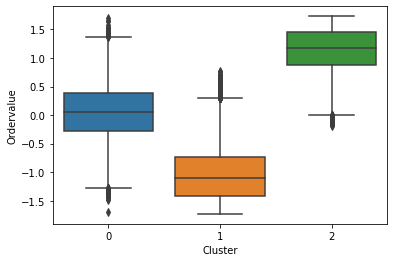

In [9]:
sns.boxplot(x='Cluster',y='Ordervalue',data=four_cluster_df)

In [7]:
#Extract cluster centres
cluster1_metrics = kmeans.cluster_centers_[0]
cluster2_metrics = kmeans.cluster_centers_[1]
cluster3_metrics = kmeans.cluster_centers_[2]
# cluster4_metrics = kmeans.cluster_centers_[3]

data = [cluster1_metrics, cluster2_metrics, cluster3_metrics] 
cluster_center_df = pd.DataFrame(data)

cluster_center_df.columns = four_cluster_df.columns[0:2]

cluster_center_df


,Ordervalue,Frequency
0,-1.034704,-1.050825
1,1.153611,1.153458
2,0.059368,0.078017


## Plots

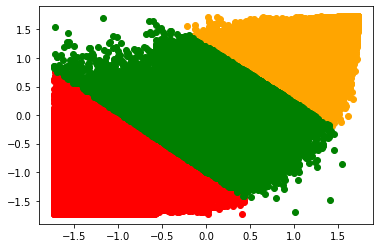

In [8]:


plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['Frequency'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['Ordervalue'],
    c='red',label='0')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['Frequency'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['Ordervalue'],
    c='orange',label='1')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['Frequency'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['Ordervalue'],
    c='green',label='2')

# plt.scatter(
#     four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['Frequency'], 
#     four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['Ordervalue'],
#     c='brown',label='3')

# plt.title('Order value vs. OrderCount Clusters')
# plt.xlabel('Order Count')
# plt.ylabel('Order value ')
# plt.legend(loc='lower right')
# plt.grid(False)
# plt.savefig('sales_order_with_scaling')
# plt.show()

# plt.scatter(
#     four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['Frequency'], 
#     four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
#     c='red',label='0')

# plt.scatter(
#     four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['Frequency'], 
#     four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
#     c='orange',label='1')

# plt.scatter(
#     four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['Frequency'], 
#     four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
#     c='green',label='2')

# # plt.scatter(
# #     four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['Frequency'], 
# #     four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
# #     c='brown',label='3')




# plt.title('AvgOrderValue vs. OrderCount Clusters\nWith scaling')
# plt.xlabel('Order Count')
# plt.ylabel('Avg Order Value')
# plt.legend(loc='lower right')
# plt.grid(False)
# plt.savefig('avg_value_order_with_scaling')
# plt.show()


# plt.scatter(
#     four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['Ordervalue'], 
#     four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
#   c='red',label='0')

# plt.scatter(
#     four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['Ordervalue'], 
#     four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
#   c='orange',label='1')

# plt.scatter(
#     four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['Ordervalue'], 
#     four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
#      c='green',label='2')

# # plt.scatter(
# #     four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'], 
# #     four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
# #      c='brown',label='3')


# plt.legend()
# plt.title('AvgOrderValue vs. Ordervalue Clusters\nWith scaling')
# plt.xlabel('Order value')
# plt.ylabel('Avg Order Value')

# plt.grid(False)
# plt.savefig('avg_value_sales_with_scaling')
# plt.show()
